In [1]:
from ftlangdetect import detect
from germansentiment import SentimentModel
import pandas as pd
import swifter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Eric
[nltk_data]     User\AppData\Roaming\nltk_data...


True

In [2]:
model = SentimentModel()
sia = SentimentIntensityAnalyzer()

def predict_sentiments(row):
    if 'language' not in row or row['language'] =='de':
        classes, probabilities = model.predict_sentiment([row['comments']], output_probabilities = True)
        return pd.Series({
            'sentiment': classes[0], 
            'positive_sentiment': probabilities[0][0][1], 
            'negative_sentiment': probabilities[0][1][1], 
            'neutral_sentiment': probabilities[0][2][1]
        })
    else:
        sentiments = sia.polarity_scores(row['comments'])
        sentiment_label = max(sentiments, key=lambda x: sentiments[x] if x in ['pos', 'neg', 'neu'] else -1)
        sentiment_map = {'pos': 'positive', 'neg': 'negative', 'neu': 'neutral'}

        return pd.Series({
            'sentiment': sentiment_map[sentiment_label], 
            'positive_sentiment': sentiments['pos'], 
            'negative_sentiment': sentiments['neg'], 
            'neutral_sentiment': sentiments['neu']
        }) 
    
def detect_language(text):
    try:
        result = detect(text=text, low_memory=False)
        return result['lang']
    except Exception as e:
        return None


## unused
#def translate(text, source_language, target_language):
#    try:
#        model_name = f'Helsinki-NLP/opus-mt-{source_language}-{target_language}'
#        tokenizer = MarianTokenizer.from_pretrained(model_name)
#        model = MarianMTModel.from_pretrained(model_name)
#
#        inputs = tokenizer.encode(text, return_tensors="pt")
#        outputs = model.generate(inputs, num_beams=4, max_length=50, early_stopping=True)
#        translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
#
#        return translated_text
#    except:
#        print(f'Helsinki-NLP/opus-mt-{source_language}-{target_language} doesnt exist')
#        return GoogleTranslator(source='auto', target=target_language).translate(text)
#
#def translate_row(row):
#    if row['language'] == 'en' or row['language'] == 'de':
#        return row['comments']
#    return translate(row['comments'], row['language'], 'en')    
#

In [4]:
model.predict_sentiment(["die Wohnung stinkt", "die Wohnung stinkt nicht", "die Wohnung duftet"], output_probabilities = True)

(['negative', 'neutral', 'neutral'],
 [[['positive', 0.006085917353630066],
   ['negative', 0.8650097250938416],
   ['neutral', 0.12890440225601196]],
  [['positive', 0.004299186170101166],
   ['negative', 0.12155681103467941],
   ['neutral', 0.8741439580917358]],
  [['positive', 0.0009776402730494738],
   ['negative', 0.0030818465165793896],
   ['neutral', 0.9959405660629272]]])

In [11]:
# Andere Sprachen werden falsch predictet.
model.predict_sentiment(["В квартире было грязно и воняло.", "El apartamento era muy bonito.", "Die Wohnung war dreckig und hat gestunken.", "Die Wohnung war sauber."], output_probabilities = True)

(['negative', 'negative', 'neutral', 'positive'],
 [[['positive', 0.126670241355896],
   ['negative', 0.8723633289337158],
   ['neutral', 0.0009664089884608984]],
  [['positive', 0.28107449412345886],
   ['negative', 0.6973143219947815],
   ['neutral', 0.021611185744404793]],
  [['positive', 0.0007139815716072917],
   ['negative', 0.2380208820104599],
   ['neutral', 0.761265218257904]],
  [['positive', 0.9703390002250671],
   ['negative', 0.028706924989819527],
   ['neutral', 0.0009540801402181387]]])

# Title Sentiments

In [41]:
df_airbnb = pd.read_csv('../data/airbnb/March_2024/listings.csv')
df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13362 entries, 0 to 13361
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13362 non-null  int64  
 1   name                            13362 non-null  object 
 2   host_id                         13362 non-null  int64  
 3   host_name                       13353 non-null  object 
 4   neighbourhood_group             13362 non-null  object 
 5   neighbourhood                   13362 non-null  object 
 6   latitude                        13362 non-null  float64
 7   longitude                       13362 non-null  float64
 8   room_type                       13362 non-null  object 
 9   price                           8400 non-null   float64
 10  minimum_nights                  13362 non-null  int64  
 11  number_of_reviews               13362 non-null  int64  
 12  last_review                     

In [ ]:
df_airbnb[['sentiment', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment']] = df_airbnb.swifter.apply(predict_sentiments)

In [45]:
df_airbnb[['id', 'sentiment', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment']].to_csv("../data/airbnb/March_2024/sentiments.csv", index=False)

# Review Sentiments

In [13]:
df_airbnb = pd.read_csv('../data/airbnb/March_2024/listings.csv')
df_reviews = pd.read_csv('../data/airbnb/March_2024/reviews.csv')
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503153 entries, 0 to 503152
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     503153 non-null  int64 
 1   id             503153 non-null  int64 
 2   date           503153 non-null  object
 3   reviewer_id    503153 non-null  int64 
 4   reviewer_name  503153 non-null  object
 5   comments       503116 non-null  object
dtypes: int64(3), object(3)
memory usage: 23.0+ MB


In [12]:
filtered_reviews = df_reviews[df_reviews['listing_id'].isin(df_airbnb['id'])]
filtered_reviews = filtered_reviews.dropna(subset=["comments"])
filtered_reviews['language'] = filtered_reviews['comments'].apply(detect_language)
filtered_reviews = filtered_reviews[filtered_reviews['language'].isin(['de', 'en'])]

In [ ]:
filtered_reviews[['sentiment', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment']] = filtered_reviews.apply(predict_sentiments)

In [ ]:
filtered_reviews[['id', 'sentiment', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'date', 'listing_id', 'language']].to_csv("../data/airbnb/review_sentiments.csv", index=False)

In [3]:
df_review_sentiments = pd.read_csv('../data/airbnb/review_sentiments.csv')
df_review_sentiments.head(5)

,id,sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,date,listing_id,language
0,4283,positive,0.991684,0.008207,0.000109,2009-06-20,3176,en
1,14159242,positive,0.999650,0.000340,0.000009,2014-06-13,265408,de
2,27230771,negative,0.051247,0.948726,0.000027,2015-02-28,265408,en
3,134722,positive,0.987947,0.011883,0.000169,2010-11-07,3176,en
4,144064,neutral,0.001159,0.002875,0.995966,2010-11-24,3176,en


# Visualizations

In [4]:
import pandas as pd
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import spacy

nlp = spacy.load('en_core_web_sm')

In [5]:
df_reviews = pd.read_csv('../data/airbnb/March_2024/reviews.csv')
df_airbnb = pd.read_csv('../data/airbnb/March_2024/listings.csv')

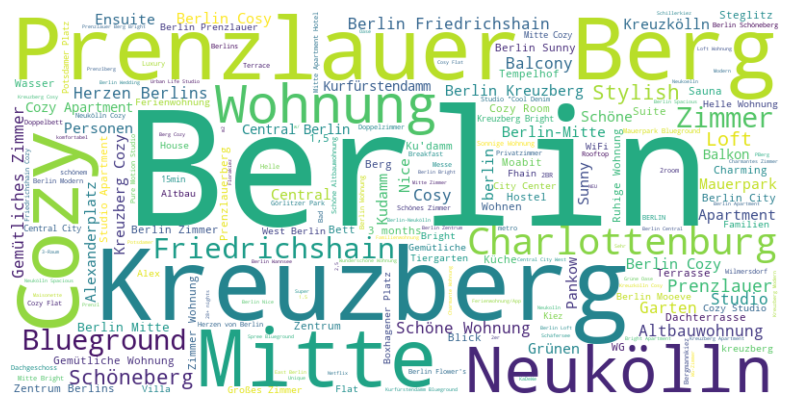

In [6]:
text = ' '.join(df_airbnb['name'])
doc = nlp(text)
entities = [ent.text for ent in doc.ents]
stop_words = set(nlp.Defaults.stop_words)
filtered_entities = [entity for entity in entities if not entity.isdigit() and entity.lower() not in stop_words]
entity_freq = Counter(filtered_entities)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(entity_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

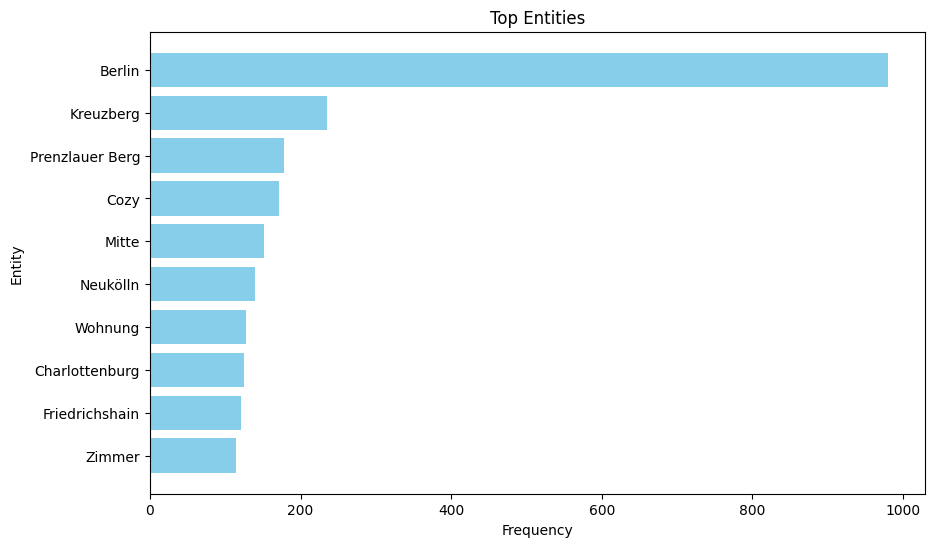

In [7]:
top_entities = entity_freq.most_common(10)

plt.figure(figsize=(10, 6))
plt.barh([entity[0] for entity in top_entities], [entity[1] for entity in top_entities], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.title('Top Entities')
plt.gca().invert_yaxis()
plt.show()